# Modificacion del NN-from-scratch para predecir un valor continuo

## Imports

In [231]:
import numpy as np
#Serelizar y deserializar objetos Python
import pickle
#Dataset 
from sklearn.datasets import fetch_openml
#Paths
import os.path

## Framework

### Funciones

In [232]:
"""
Definición de funciones de activación, derivadas 
"""
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_grad(sigmoid):
    """
    NOTA: Observe que recibe el sigmoid ya calculado
    """
    return sigmoid * (1.0 - sigmoid)

def relu(x):
    return x * (x > 0)

def relu_grad(x):
    return 1.0 * (x > 0)

def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def logloss (x, y):
    probs = softmax(x)
    return probs, y * np.log(probs)* -1

def batch_hits(x, y):
    """ Aciertos """
    return np.sum(np.argmax(x, axis=1) == y)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

### Base

In [233]:
class base():
    """ Codigo de clase base para crear una capa
        Cada capa debe de implementar su método de forward y backward
        Además debe de almacenar el calculo de self.grads
    """
    def __init__(self, input_size, output_size, use_xavier = True) -> None:
        self.input_size = input_size
        self.output_size = output_size
        if use_xavier:
            self._xavier_initialization() 
        else:
            self._initialization_uniform()
        self.o = np.zeros(output_size)
        self.x = None # Asignado durante el forward

    def _initialization_uniform(self):
        self.W = np.random.randn(self.input_size, self.output_size)
        self.b = np.random.randn(self.output_size)
        
    def _xavier_initialization(self):
        """
        Understanding the difficulty of training deep feedforward neural networks
        Xavier Glorot, Yoshua Bengio
        """
        self.W = np.random.randn(self.input_size, self.output_size) / np.sqrt(self.input_size)
        # self.b = np.random.randn(self.output_size)
        self.b = np.zeros(self.output_size)  # Mejor usar ceros aquí <---------------------------------------------------------
    
    def forward(self, x):
        pass
    
    def backward(self, prev):
        pass

    def update(self, lr):
        self.W += lr * np.dot(self.x.T, self.grads)
        self.b += lr * np.mean(self.grads, axis = 0)

### Loss Layer para regresion

In [234]:
class regression_output_layer(base):
    """
    Capa de salida para regresión.
    No aplica activación, calcula MSE como pérdida.
    """
    def __init__(self, input_size, output_size):
        super().__init__(input_size, output_size)
        self.grads = np.zeros((output_size, input_size))
    
    def forward(self, x):
        self.x = x
        if np.any(np.isnan(x)) or np.any(np.isinf(x)):
            print("⚠️ Input x contiene NaN o inf")

        if np.any(np.isnan(self.W)) or np.any(np.isinf(self.W)):
            print("⚠️ self.W contiene NaN o inf")
            
        if np.any(np.isnan(self.b)) or np.any(np.isinf(self.b)):
            print("⚠️ self.b contiene NaN o inf")

        self.output = np.dot(x, self.W) + self.b  
        self.output = np.clip(self.output, -100, 100)  # evita salidas enormes # <------------------------------------------------------------

        if np.any(np.isnan(self.output)) or np.any(np.isinf(self.output)):
            print("⚠️ self.output contiene NaN o inf")

        return self.output

    def backward(self, y_true):
        # Derivada de MSE respecto a la salida: dL/dy = (y_pred - y_true)
        self.grads = -(y_true - self.output)
    
    def loss(self, y_true):
        return np.mean((self.output - y_true) ** 2)

### Dense Layer

In [235]:
class dense(base):
    """
    Dense o FullyConnected 
    Recibe tamaños de entrada y salida, mas la funcion de activacion y su derivada.
    """
    def __init__(self, input_size, output_size, func_acivation, func_acivation_grad):
        super().__init__(input_size, output_size)
        self.grads = np.zeros((output_size, input_size))
        self.func_activation = func_acivation
        self.func_acivation_grad = func_acivation_grad
        
    def forward(self, x):
        self.x = x
        self.linear = np.dot(x, self.W) + self.b
        self.o = self.func_activation(self.linear)
        return self.o 

    def backward(self, prev):
        # al-2 < al-1 < al.x  
        # al = prev = sigmoid(x)
        self.grads = self.func_acivation_grad(prev.x) * np.dot(prev.grads, prev.W.T)

## Definicion del Modelo

In [236]:
class model():
    """
    Representa todo el modelo, el tamaño de entrada  y salida de la red,
    una lista con el tamaño que debe llevar cada capa oculpa, y las funciones de activación
    y gradiente que van a tener todas las capas ocultas
    NOTA: Todas las capas ocultas tienen la misma funcion. 
    """
    def __init__(self, input_size, output_size, hidden_shapes, func_acti, func_acti_grad):
        assert(len(hidden_shapes) > 0), "Debe tener al menos 1 capa oculta"
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_shapes = hidden_shapes
        self.hidden_amount = len(self.hidden_shapes)
        self.hidden_layers = [] #Bucket de capas ocultas
        self._populate_layers(func_acti, func_acti_grad)

    def _populate_layers(self, func_acti, func_acti_grad):
        """
        Crea todas las capas ocultas de acuerdo al input size y hidden_shapes
        Agrega una capa final de perdida
        """
        input_size = self.input_size
        for i in range(0, self.hidden_amount):
            new_dense_layer = dense(input_size, self.hidden_shapes[i], func_acti, func_acti_grad)
            self.hidden_layers.append(new_dense_layer)
            input_size = self.hidden_shapes[i]

        """
        Cambio del loss layer a la nueva clase para hacer prediccion de un valor continuo <---------------------------------
        """
        self.loss_layer = regression_output_layer(input_size, self.output_size)

    def forward(self,x, y):
        """ Propaga las entradas a traves de la red 
        Returna las probabilidades y la perdida"""
        data = x
        for i in range(0, self.hidden_amount):
            data = self.hidden_layers[i].forward(data)
        
        self.o = self.loss_layer.forward(data)
        loss = self.loss_layer.loss(y)
        
        
        return self.o, loss
    
    def predict(self, x):
        """ Propaga las entradas a traves de la red 
        Returna las probabilidades"""
        data = x
        for i in range(0, self.hidden_amount):
            data = self.hidden_layers[i].forward(data)
        
        return self.loss_layer.forward(data)
    
    def backward(self, y, o):
        #Calcula la gradiente de la perdida con respecto a la etiqueta Y
        self.loss_layer.backward(y)
        prev = self.loss_layer

        for i in reversed(range(self.hidden_amount)):
            #Propaga la capa para el calculo de gradientes en cada una
            self.hidden_layers[i].backward(prev)
            prev = self.hidden_layers[i]

    def update(self, lr):
        """ Ejecuta la actualización de parametros para cada capa
            despues de actualizar los gradientes
        """
        for i in range(self.hidden_amount):
            self.hidden_layers[i].update(lr)
        self.loss_layer.update(lr)

## Dataset

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import pickle

# 1. Cargar datos
housing = fetch_california_housing()

X, y = housing.data, housing.target.reshape(-1, 1)  # reshaped para tener forma (n,1)

# 2. Normalizar características y salida
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# 3. Guardar para simular la carga como en MNIST
with open("california.ds", "wb") as f:
    pickle.dump((X, y), f)

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude        Target  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

In [238]:
def _shuffle(x, y):
    assert(len(x) == len(y)), "Make sure data and labels have the same lenght!"
    rand_indexes = np.random.permutation(len(x))
    return x[rand_indexes], y[rand_indexes]

#represents a dataset, useful for val dataset, train dataset and test dataset.
class dataset():
    def __init__(self, x, y, batch_size):
        #assert(len(y) % batch_size == 0), "Make sure batch size divides number of items perfectly!"
        self.compl_x = x[:]
        self.compl_y = y[:]
        self.batch_size = batch_size
        self.reset()
        self.size = len(self.compl_y)

    def shapes(self):
        return ( self.compl_x.shape, self.compl_y.shape )

    def view(self):
        print(self.compl_x, self.compl_y)

    #iterate over the dataset
    def next(self):
        if self.left_items < self.batch_size:
            x = self.x[self.current:]
            y = self.y[self.current:]
            self.current += len(self.x)
            self.left_items = 0
            return x, y
        else:
            x = self.x[self.current:self.current+self.batch_size]
            y = self.y[self.current:self.current+self.batch_size]
            self.current += self.batch_size
            self.left_items -= self.batch_size
            return x, y

    def iter_done(self):
        return self.left_items == 0

    def reset(self):
        self.x = self.compl_x[:]
        self.y = self.compl_y[:]
        self.x, self.y = _shuffle(self.x, self.y)
        self.current = 0
        self.left_items = len(self.compl_y)

#splits a complete dataset into 3 subsets for train, val and test, by percentage
class dataset_splitter():
    def __init__(self, x, y, batch_size, perc_train=0.8, perc_val=0.2):
        self.x = x
        self.y = y
        self.split(batch_size, perc_train, perc_val)

    def _split_by_limits(self, batch_size, train_limit, val_limit):
        #Crea los dataset de entrenamiento, validación y testing
        self.ds_train = dataset(self.x[:train_limit], self.y[:train_limit], batch_size)
        self.ds_train.reset()
        self.ds_val = dataset(self.x[train_limit:val_limit], self.y[train_limit:val_limit], batch_size)
        self.ds_val.reset()
        self.ds_test = dataset(self.x[val_limit:], self.y[val_limit:], batch_size)
        self.ds_test.reset()

    def split(self, batch_size, perc_train, perc_val):
        self.x, self.y = _shuffle(self.x, self.y)
        n = len(self.x)
        train_limit = int(n * perc_train)
        temp = int(train_limit * (1.0 - perc_val))
        val_limit = train_limit - temp
        train_limit = temp
        #print(n, train_limit, val_limit)
        self._split_by_limits(batch_size, train_limit, train_limit+val_limit)
        print(self.ds_train.shapes(), self.ds_val.shapes(), self.ds_test.shapes())
        return self.ds_train, self.ds_val, self.ds_test

## Hyperparameters

In [239]:
# Cargar el dataset California Housing
with open("california.ds", "rb") as f:
    X, y = pickle.load(f)

batch_size = 64
epochs = 50
input_size = X.shape[1]  # 8 atributos
output_size = 1  # valor continuo
hidden_shapes = [64, 32, 16]
lr = 0.01
output_log = "housing_log.txt"

data = dataset(X, y, batch_size)
splitter = dataset_splitter(data.compl_x, data.compl_y, batch_size, 0.8, 0.2)
ds_train = splitter.ds_train
ds_val = splitter.ds_val
ds_test = splitter.ds_test


((13209, 8), (13209, 1)) ((3303, 8), (3303, 1)) ((4128, 8), (4128, 1))


In [240]:
class ConfigEnum:
    MNIST = range(1)

#factory-like class which produces different configs for each dataset tested
class hyperparams():

    def __init__(self, config_enum=1): #default is iris based on reqs
        
    
        self.batch_size = batch_size
        self.validate_every_no_of_batches = 600
        self.epochs = epochs
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_shapes = hidden_shapes
        self.lr = lr
        self.output_log = output_log
        self.ds_train = ds_train
        self.ds_test = ds_test
        self.ds_val = ds_val

    def split_again(self, perc_train, perc_val):
        self.ds_train, self.ds_val, self.ds_test = self.splitter.split(self.batch_size, perc_train, perc_val)

## Ejecucion

In [241]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import csv
import numpy as np


class nnlogger():
    def __init__(self, output_file, header):
        self.csv_file = open(output_file, "w")
        self.writer = csv.writer(self.csv_file, delimiter=',')
        self.writer.writerow( header )

    def write(self, line):
        self.writer.writerow( line )

    def close(self):
        self.csv_file.close()

class historian():

    def __init__(self, figsize=(8,6)):
        self.iter = []
        self.acc =  []
        self.loss = []

    def add(self, iter, loss, accuracy):
        self.iter += [ iter ]
        self.acc +=  [ accuracy ]
        self.loss += [ loss ]


class nnplotter():

    @classmethod
    def view(cls, val_history, train_history):
        ax = plt.subplot(2, 1, 1)
        ax.plot(val_history.iter, val_history.loss, 'b--', label="val")
        ax.plot(train_history.iter, train_history.loss, 'r--', label="train")
        plt.ylabel("loss")
        ax.legend()

        ax2 = plt.subplot(2, 1, 2)
        ax2.plot(val_history.iter, val_history.acc, 'b--', label="val")
        ax2.plot(train_history.iter, train_history.acc, 'r--', label= "train")
        plt.ylabel("accuracy")
        plt.xlabel("iteration")
        ax2.legend()

        plt.show()

In [242]:
def train(nn, hp, val_hist, train_hist, logger):
    cur_epoch = 1
    cur_iter = 1
    for i in range(1, hp.epochs+1):
        train_loss = 0
        batches = 0
        while not hp.ds_train.iter_done():
            x, y = hp.ds_train.next()
            o, batch_loss = nn.forward(x, y)
            nn.backward(y, o)
            nn.update(hp.lr)

            train_loss += np.mean(batch_loss)
            batches += 1

            if cur_iter % hp.validate_every_no_of_batches == 0:
                avg_train_loss = train_loss / batches
                train_hist.add(cur_iter, avg_train_loss, 0.0)  # No accuracy en regresión
                logger.write((cur_epoch, "Training", cur_iter, 0.0, avg_train_loss))

                val_loss = test(nn, hp.ds_val, verbose=True)
                val_hist.add(cur_iter, val_loss, 0.0)
                logger.write((cur_epoch, "Val", cur_iter, 0.0, val_loss))

                # Reset
                train_loss = 0
                batches = 0
            cur_iter += 1

        cur_epoch += 1
        hp.ds_train.reset()
    return val_hist

def test(nn, ds, verbose=False, phase="Validation"):
    ds.reset()
    total_loss = 0
    batches = 0

    while not ds.iter_done():
        x, y = ds.next()
        o, batch_loss = nn.forward(x, y)
        total_loss += np.mean(batch_loss)
        batches += 1

    mean_loss = total_loss / batches

    if verbose:
        print(f"{phase} Loss: {mean_loss:.4f}")

    return mean_loss

## Ejecucion Regresion (new Dataset)

### Training

Validation Loss: 10018.4801
Validation Loss: 10017.7708
Validation Loss: 10017.8622
Validation Loss: 10017.8161
Validation Loss: 10017.7589
Validation Loss: 10017.7702
Validation Loss: 10017.6574
Validation Loss: 10017.7137
Validation Loss: 10017.4754
Validation Loss: 10017.4004
Validation Loss: 10018.2160
Validation Loss: 10018.0188
Validation Loss: 10017.9811
Validation Loss: 10017.9607
Validation Loss: 10017.9375
Validation Loss: 10018.1232
Validation Loss: 10018.0619
True values: [1.125 2.233 1.596 0.633 2.125]
Predicted: [ 117.46137857  117.46137857  117.46137857  117.46137857 -113.32426224]
MSE: 9864.263088800002


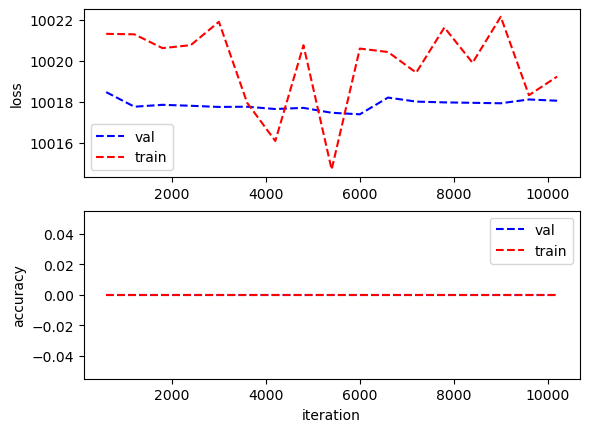

In [243]:
hp = hyperparams()
nn = model(hp.input_size, hp.output_size, hp.hidden_shapes, tanh, tanh_derivative)
val_hist = historian()
train_hist = historian()
logger = nnlogger(hp.output_log, ("Epoch", "Phase", "Iteration", "Accuracy", "Loss"))  # accuracy puede no tener sentido en regresión

train(nn, hp, val_hist, train_hist, logger)

# Predicción para evaluar error real (desnormalizado)
y_pred = nn.predict(hp.ds_test.compl_x[:5])
y_real = scaler_y.inverse_transform(hp.ds_test.compl_y[:5])
y_pred_real = scaler_y.inverse_transform(y_pred)

print("True values:", y_real.flatten())
print("Predicted:", y_pred_real.flatten())

mse = np.mean((y_real - y_pred) ** 2)
print("MSE:", mse)

nnplotter.view(val_hist, train_hist)
logger.close()